In [67]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE

In [64]:
df = pd.read_csv("data/output/df.csv")
processed_df = pd.read_csv("data/output/processed_df.csv")

In [65]:
def recommend_map_knn(level, job, level_range=5):
    # Data Preprocessing: Remove rows with missing values in important columns
    df_cleaned = df.dropna(subset=['level', 'spec_filled', 'map'])
    
    # Filter the dataset to use only the data corresponding to the input job
    relevant_data = df_cleaned[(df_cleaned['level'] >= level - level_range) & 
                               (df_cleaned['level'] <= level + level_range) & 
                               (df_cleaned['job'] == job)]
    
    if relevant_data.empty:
        return "No data available for this job/level combination within the specified range."

    # Prepare feature matrix (X) for KNN model: 'level', 'spec_filled'
    X = relevant_data[['level', 'spec_filled']].values
    maps_relevant = relevant_data['map'].values

    # KNN Model for finding similar maps based on features
    knn_relevant = NearestNeighbors(n_neighbors=3, algorithm='auto', metric='euclidean')
    knn_relevant.fit(X)

    # Create a feature vector for the input (level, spec_filled)
    input_spec_filled = relevant_data['spec_filled'].mean()  # Use the mean spec_filled value for input
    input_vector = np.array([[level, input_spec_filled]])

    # Find the top 3 nearest neighbors (maps) based on the input features
    distances, indices = knn_relevant.kneighbors(input_vector)
    
    # Get the top 3 map recommendations and their corresponding distances
    recommended_maps = maps_relevant[indices.flatten()]
    recommendation_scores = distances.flatten()

    # Remove duplicate maps if any
    recommended_maps = list(dict.fromkeys(recommended_maps))[:3]  # Limit to 3 unique maps

    # Sort the recommendations by raw distance (lower distance is better)
    sorted_recommendations = sorted(zip(recommended_maps, recommendation_scores), key=lambda x: x[1])

    # Visualize the KNN results
    if isinstance(recommended_maps, list):
        maps = relevant_data['map'].values
        levels = relevant_data['level'].values
        spec_filled = relevant_data['spec_filled'].values
        
        # Plot all data points
        plt.figure(figsize=(8, 6))
        plt.scatter(levels, spec_filled, c='gray', label='Data points', alpha=0.5)

        # Highlight the query point
        plt.scatter(level, input_spec_filled, c='red', label='Query point', s=100, marker='x')

        # Highlight the nearest neighbors
        nearest_neighbors = X[indices.flatten()]
        plt.scatter(nearest_neighbors[:, 0], nearest_neighbors[:, 1], c='blue', label='Nearest neighbors', s=100, marker='o')

        # Labels and title
        plt.xlabel('Level')
        plt.ylabel('Spec Filled')
        plt.title(f"KNN Visualization for Job: {job} and Level: {level}")
        plt.legend()

        # Show plot
        plt.show()
        
        # Output the recommended maps and their scores (raw distance)
        # Print the similarity scores
        print("Similarity scores for recommended maps:")
        for map_name, score in zip(recommended_maps, recommendation_scores):
            print(f"Map: {map_name}, Score: {score}")
        print("Recommended Maps and Scores:", recommended_maps)

    return sorted_recommendations

# Example usage
# recommended_maps = recommend_map_knn(140, "썬콜", level_range=5)

In [66]:
# Function to get map recommendations based on a given level and job
def recommend_map_svd(level, job, level_range=5):

    # Filter out rows that do not belong to the specified job
    df_job_filtered = df[df['job'] == job]

    # Data Preprocessing: Remove rows with missing values in important columns
    df_cleaned = df_job_filtered.dropna(subset=['level', 'job', 'spec_filled', 'map'])
    
    # Calculate map usage frequency for each job
    map_usage_frequency = df_cleaned.groupby(['job', 'map']).size().reset_index(name='usage_count')
    
    # Calculate the total number of interactions for each job
    job_total_count = df_cleaned.groupby('job').size().reset_index(name='total_count')
    
    # Merge the usage count with the total count for each job
    map_usage_frequency = pd.merge(map_usage_frequency, job_total_count, on='job')
    
    # Calculate the percentage usage for each map within each job
    map_usage_frequency['usage_percentage'] = (map_usage_frequency['usage_count'] / map_usage_frequency['total_count']) * 100
    
    # Filter out maps used in less than 5% of the total interactions for each job
    valid_maps_per_job = map_usage_frequency[map_usage_frequency['usage_percentage'] >= 5]
    
    # Now filter the original dataframe to only keep rows with maps that meet the usage threshold
    df_cleaned_filtered = df_cleaned[df_cleaned['map'].isin(valid_maps_per_job['map'])]
    
    # Prepare the data for the recommendation system
    # Create a user-item interaction matrix where rows = users (party_id), columns = maps
    user_map_matrix = df_cleaned_filtered.pivot_table(index='party_id', columns='map', values='spec_filled', aggfunc='mean').fillna(0)
    
    # Apply Matrix Factorization using TruncatedSVD
    svd = TruncatedSVD(n_components=3, random_state=42)  # Using 3 latent factors for this example
    matrix_factorized = svd.fit_transform(user_map_matrix)
    
    # Get the cosine similarity between maps in the reduced space
    map_similarity = cosine_similarity(matrix_factorized.T)

    # Filter data based on the given level and job
    level_range_min = level - level_range
    level_range_max = level + level_range
    relevant_data = df_cleaned_filtered[(df_cleaned_filtered['level'] >= level_range_min) & 
                                       (df_cleaned_filtered['level'] <= level_range_max) & 
                                       (df_cleaned_filtered['job'] == job)]
    
    if relevant_data.empty:
        return "No data available for this job/level combination within the specified range."

    # Get the list of maps from the filtered data
    maps_relevant = relevant_data['map'].unique()

    # Ensure that the maps are present in the user_map_matrix
    valid_maps = [map_name for map_name in maps_relevant if map_name in user_map_matrix.columns]
    
    if not valid_maps:
        return "No valid maps available for recommendation."

    # Get the index of relevant maps in the reduced matrix (svd.transform)
    map_indices = [user_map_matrix.columns.get_loc(map_name) for map_name in valid_maps]
    
    # Ensure map_indices do not exceed the range of the reduced matrix (which has 3 factors)
    map_indices = [index for index in map_indices if index < len(map_similarity)]

    # Now calculate similarity scores for each relevant map with all other maps in the reduced matrix
    scores = np.mean(map_similarity[map_indices], axis=0)

    # Sort the scores and get top 3 recommended maps
    recommended_indices = np.argsort(scores)[::-1][:3]
    recommended_maps = user_map_matrix.columns[recommended_indices]
    
    # Visualization of the SVD components and map recommendations
    # Visualize the maps in the SVD space (2D for simplicity)
    plt.figure(figsize=(10, 8))
    
    # Plot all maps in the reduced space (SVD components)
    plt.scatter(matrix_factorized[:, 0], matrix_factorized[:, 1], label="Maps", alpha=0.5, c='gray')
    
    # Highlight the recommended maps in a different color
    for idx in recommended_indices:
        plt.scatter(matrix_factorized[idx, 0], matrix_factorized[idx, 1], label=f"Recommended: {recommended_maps[idx]}", s=100, edgecolors='black')
    
    # Add labels for the recommended maps
    for idx in recommended_indices:
        plt.annotate(recommended_maps[idx], (matrix_factorized[idx, 0], matrix_factorized[idx, 1]), fontsize=12, ha='right', color='black')

    # Labeling and formatting the plot
    plt.title(f"SVD Map Visualization for Job: {job} and Level: {level}")
    plt.xlabel("SVD Component 1")
    plt.ylabel("SVD Component 2")
    plt.legend()
    plt.show()

    # Print the unique maps after preprocessing
    print("Unique maps after preprocessing:")
    print(df_cleaned_filtered['map'].unique())

    # Print the similarity scores
    print("Similarity scores for recommended maps:")
    for map_name, score in zip(recommended_maps, scores[recommended_indices]):
        print(f"Map: {map_name}, Score: {score}")
    
    # Output the recommended maps
    print("Recommended Maps:", recommended_maps)
    # Return the top 3 recommended maps
    return recommended_maps.tolist()

# Example usage
# recommended_maps = recommend_map_svd(140, "썬콜", level_range=5)

In [70]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Step 1: Preprocess the data for t-SNE
def preprocess_data_for_tsne(df, numerical_features=["level", "spec_filled"], categorical_features=["job", "map"]):
    """
    Preprocesses the data for t-SNE:
    - Encodes categorical features (e.g., job, map).
    - Imputes missing values for numerical features (not filling with 0).
    - Normalizes numerical features.
    """
    # One-Hot Encode categorical features (e.g., job, map)
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded_cats = encoder.fit_transform(df[categorical_features])
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

    # Impute missing values for numerical columns with the mean (instead of filling with 0)
    imputer = SimpleImputer(strategy='mean')
    df[numerical_features] = imputer.fit_transform(df[numerical_features])  # Impute missing numerical values

    # Normalize numerical features (including spec_filled)
    scaler = StandardScaler()
    normalized_nums = scaler.fit_transform(df[numerical_features])
    normalized_df = pd.DataFrame(normalized_nums, columns=numerical_features)

    # Combine numerical and categorical features
    combined_df = pd.concat([normalized_df, encoded_df], axis=1)
    return combined_df

# Step 2: Apply t-SNE to the data
def apply_tsne(df, perplexity=30, learning_rate=200, n_iter=1000):
    """
    Apply t-SNE to the dataset and return the 2D results.
    """
    # Preprocess the data
    processed_data = preprocess_data_for_tsne(df)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(processed_data)

    # Add t-SNE results to the DataFrame
    df["tsne_dim1"] = tsne_results[:, 0]
    df["tsne_dim2"] = tsne_results[:, 1]

    return df

# Step 3: Identify outliers based on t-SNE results and filter the top 0.1%
def filter_outliers_by_tsne(df, top_percentile=99.9):
    """
    Filter out the top n% (e.g., 0.1%) outliers based on t-SNE distance.
    """
    # Using NearestNeighbors to compute distances between points
    neighbors = NearestNeighbors(n_neighbors=2)  # Find the closest point (itself + 1 neighbor)
    neighbors.fit(df[["tsne_dim1", "tsne_dim2"]])
    distances, _ = neighbors.kneighbors(df[["tsne_dim1", "tsne_dim2"]])

    # Calculate the distance from the nearest neighbor
    df["distance_to_nearest"] = distances[:, 1]  # distance to the second nearest (ignoring self)

    # Calculate the threshold for the top n% outliers
    distance_threshold = np.percentile(df["distance_to_nearest"], top_percentile)
    print(f"Filtering out the top {top_percentile}% outliers with distance greater than {distance_threshold}")

    # Identify the outliers (rows that are filtered out)
    outliers = df[df["distance_to_nearest"] > distance_threshold]
    
    # Filter out the outliers from the original df
    df_filtered = df[df["distance_to_nearest"] <= distance_threshold]

    return df_filtered, outliers

# Step 4: Visualize the t-SNE results
def visualize_tsne(df):
    """
    Visualizes the t-SNE results and shows the distribution of job-map combinations.
    """
    plt.figure(figsize=(12, 8))
    
    # Create the scatter plot
    sns.scatterplot(data=df, x="tsne_dim1", y="tsne_dim2", hue="map", style="job", palette="tab20", s=100, alpha=0.7)

    # Move the legend outside of the plot area
    plt.title("t-SNE Visualization of Job-Map Combinations", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=14)
    plt.ylabel("t-SNE Dimension 2", fontsize=14)
    plt.grid(True)
    
    # Adjust legend to be outside the plot area
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Job / Map", fontsize=12)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()
    print(outliers)

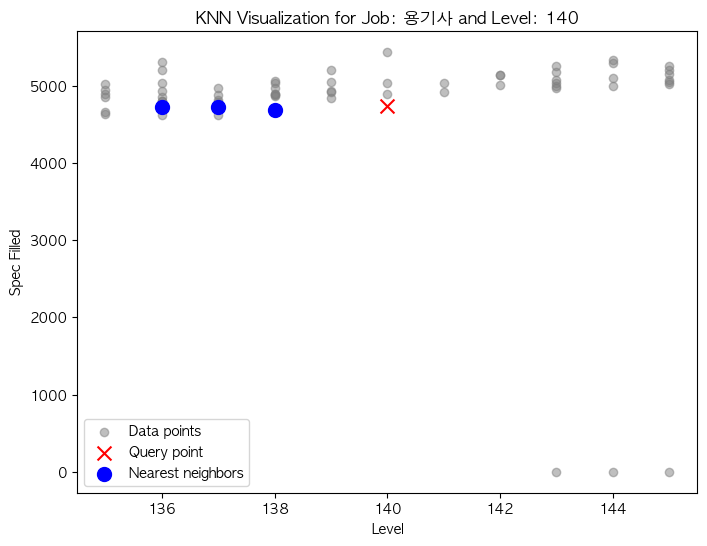

Similarity scores for recommended maps:
Map: 협동, Score: 11.193626227374054
Map: 블와둥, Score: 11.257294362068432
Recommended Maps and Scores: ['협동', '블와둥']


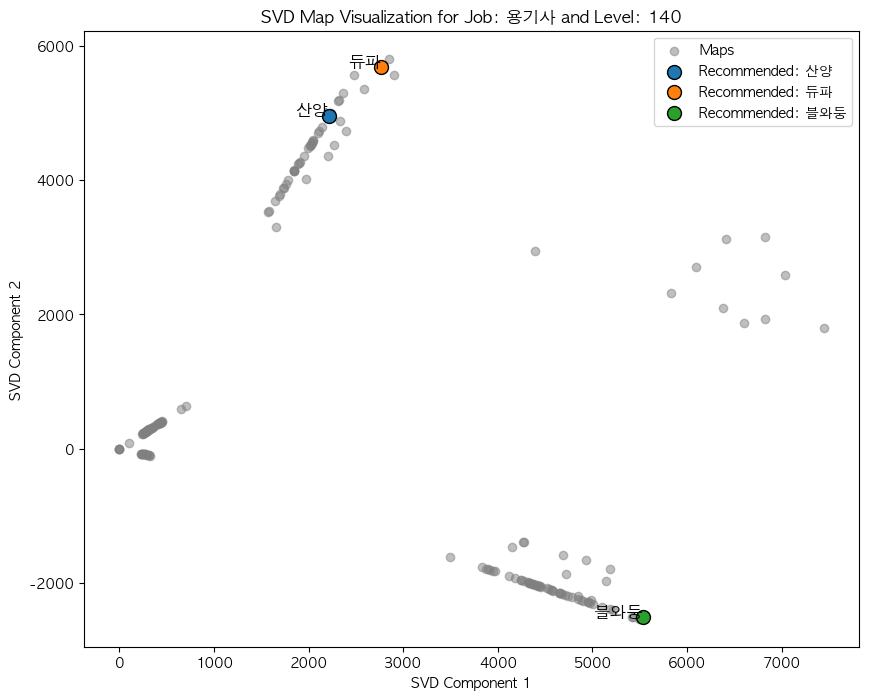

Unique maps after preprocessing:
['하둥' '협동' '블와둥' '산양' '듀파']
Similarity scores for recommended maps:
Map: 블와둥, Score: 0.49999999999999967
Map: 산양, Score: 0.49999999999999944
Map: 듀파, Score: 2.6107588313450947e-16
Recommended Maps: Index(['블와둥', '산양', '듀파'], dtype='object', name='map')
Filtering out the top 99.9% outliers with distance greater than 1.8746394017766832


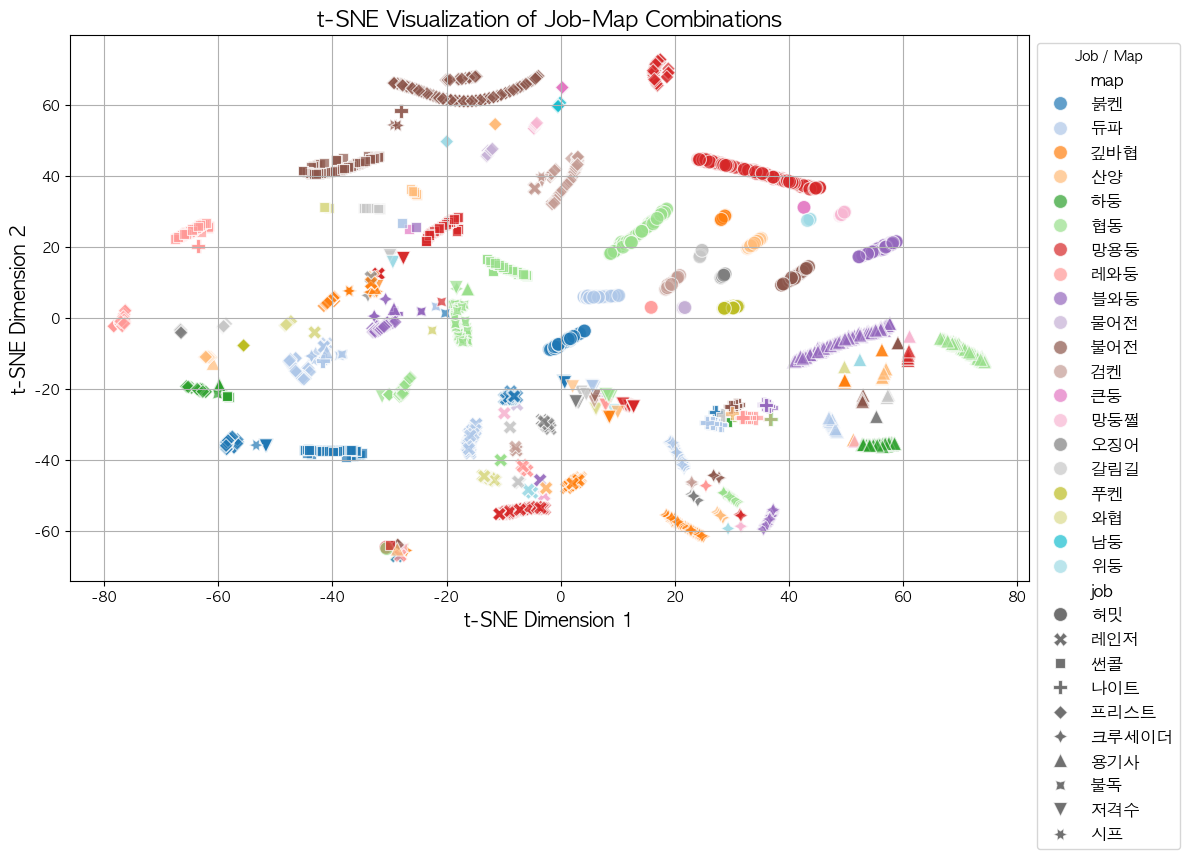

      party_id      time  level  job  spec  map        date  valid  \
93          48  오전 12:35  154.0  용기사   NaN   큰둥  2024-12-19   True   
1525       115   오후 1:32   87.0  레인저   NaN  깊바협  2024-12-11   True   
1861        32   오후 3:48  139.0   시프   NaN   듀파  2024-12-15   True   
2539       179  오전 12:45  126.0   시프   NaN  레와둥  2024-12-16   True   

      valid_spec  spec_by_level  avg_spec_by_level  spec_filled  \
93         False      34.726694          34.726694  5450.636914   
1525       False      21.206268          21.206268  1878.255344   
1861       False            NaN                NaN     0.000000   
2539       False            NaN                NaN     0.000000   

      spec_distance  avg_distance_per_job  tsne_dim1  tsne_dim2  \
93              NaN           4411.364215  56.203716  -6.615118   
1525            NaN           2298.793732  -7.907958 -26.771317   
1861            NaN                   NaN -35.730572   4.703320   
2539            NaN                   NaN -61

In [71]:
# recommended_maps = recommend_map_knn(140, "용기사", level_range=5)
# recommended_maps = recommend_map_svd(140, "용기사", level_range=5)

# df_with_tsne = apply_tsne(df)  # Apply t-SNE
# df_filtered, outliers = filter_outliers_by_tsne(df_with_tsne, top_percentile=99.9)
# visualize_tsne(df_filtered)